In [142]:
%load_ext autoreload
%autoreload 2

from src.ui import GameUI
from src.training import DQNTrainer
from src.game import CoinGame
from src.agent import CoinAgent
from torch.optim import Adam
import torch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Introduction

Consider the following problem:

*You are given $n$ coins and $k$ coin flips. Each coin has weight $p$, which is obtained by sampling from a normal distribution with mean $0.5$ and standard deviation $\sigma$
 (clipped at $0$ and $1$). How do you flip coins to maximize the number of heads?*

This project aims to train a small model on this task, and interepret what it's doing.

I wanted to explore this problem to 
- Understand how small models learn to explore and exploit.
- Understand how to do interpretability in the context of RL.
- Learn current interpretability methods.

This is a personal project I'm working on to learn and practice interpretability, and I do not aim to do SOTA research or publish this. 

# Part 1: Training a coin-flipping agent.

- [CoinAgent]: 
- [CoinGame]:
- ''GameUI'': Used to display some sort of user interface to either play the game or observe a model playing the game.

In [2]:
device = "cpu"
num_coin = 3
num_flip = 5
agent = CoinAgent(
    num_coins = num_coin, 
    num_layers = 2,
    hidden_size = 5,
    device=device
)
#agent.load_state_dict(torch.load("model_parameters/trained_agent.pt"))
game = CoinGame(
    num_coins = num_coin,
    num_flips = num_flip,
    standard_dev = 0.3
)

ui = GameUI(game)

NameError: name 'CoinAgent' is not defined

In [144]:
trainer = DQNTrainer(
    max_replay_size=1000,
    batch_size=100,
    gamma=0.99,
    start_epsilon = 0.9,
    end_epsilon = 0.00,
    tau = 0.01,
    num_episodes = 3000,
    optimizer = Adam(agent.parameters(), lr=1e-3),
    agent = agent,
    game = game,
    device=device
)
ui = GameUI(game)

100%|██████████| 3000/3000 [01:38<00:00, 30.59it/s]


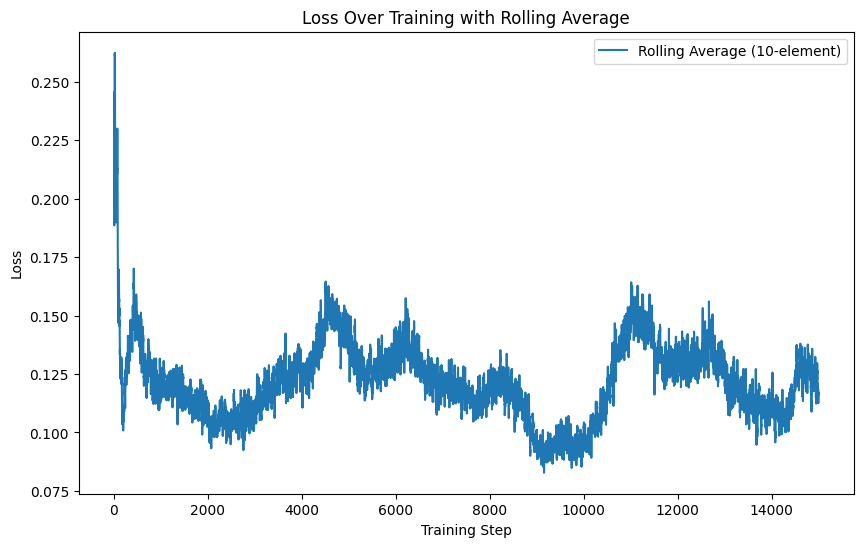

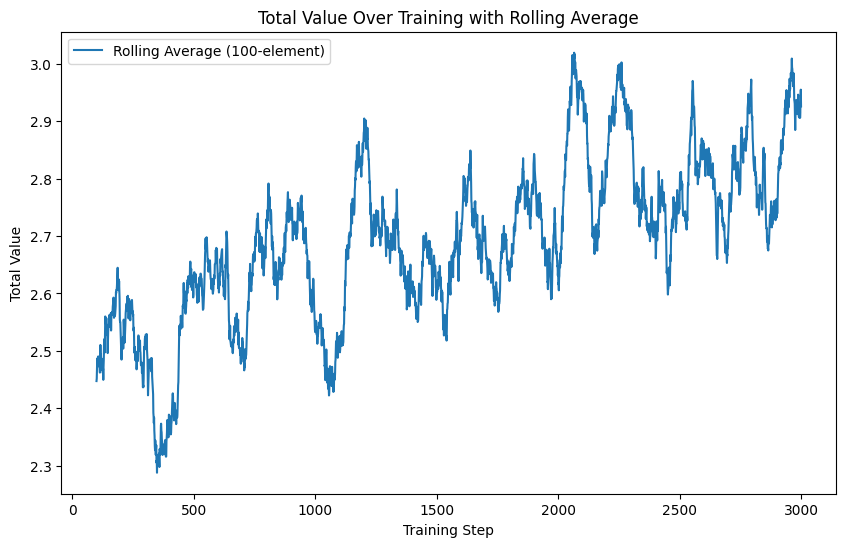

In [145]:
agent.train()
trainer.run_train_loop()
trainer.show_loss(roll_window = 10)
trainer.show_value(roll_window = 100)
torch.save(agent.state_dict(), "model_parameters/trained_agent.pt")

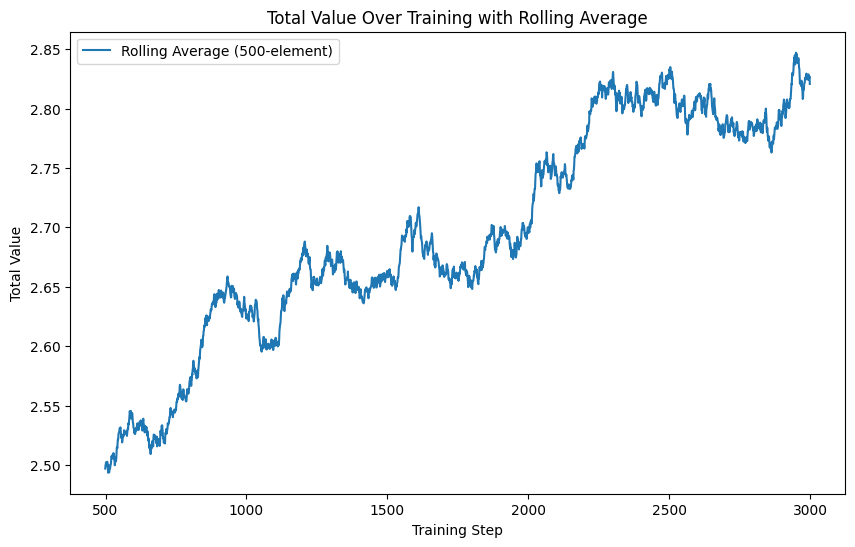

In [146]:
trainer.show_value(roll_window = 500)

In [147]:
agent.eval()
ui.run(model=agent)

-----------------------
        Heads  Tails
Coins               
Coin 0      0      0
Coin 1      0      0
Coin 2      0      0
Number of flips left: 5
-----------------------
Tails!
-----------------------
        Heads  Tails
Coins               
Coin 0      0      0
Coin 1      1      0
Coin 2      0      0
Number of flips left: 4
-----------------------
Tails!
-----------------------
        Heads  Tails
Coins               
Coin 0      0      0
Coin 1      2      0
Coin 2      0      0
Number of flips left: 3
-----------------------
Tails!
-----------------------
        Heads  Tails
Coins               
Coin 0      0      0
Coin 1      3      0
Coin 2      0      0
Number of flips left: 2
-----------------------
Tails!
-----------------------
        Heads  Tails
Coins               
Coin 0      0      0
Coin 1      4      0
Coin 2      0      0
Number of flips left: 1
-----------------------
Tails!
-----------------------
        Heads  Tails
Coins               
Coin 0      0 

In [188]:
agent.load_state_dict(torch.load("model_parameters/trained_agent.pt"))

<All keys matched successfully>

In [227]:
import random

def sample_state():
    game.reset()
    flips = random.randint(1, game.num_flips)
    for _ in range(flips):
        state, _, _ = game.step(random.randint(0, game.num_coins-1))
    return state.to_tensor()
def sample_state_probs(flip_counts=None):
    if flip_counts is None:
        flip_counts = [1, 1, 1]
    return torch.tensor([random.random(), random.random(), random.random(), *flip_counts, game.num_flips-sum(flip_counts)])
def sample_state_flips(probs = None):
    if probs is None:
        probs = [0.5, 0.5, 0.5]
    game.reset()
    flips = game.num_flips
    for _ in range(flips):
        state, _, _ = game.step(random.randint(0, game.num_coins-1))
    state_tens = state.to_tensor()
    state_tens[:3] = torch.tensor(probs)
    return state_tens

def sample_state_num_flips(flips_probs = None):
    if flips_probs is None:
        flips_probs = [0.5, 0.5, 0.5, 1, 1, 1]
    return torch.tensor([*flips_probs, random.randint(1, game.num_flips)])

print(sample_state())
print(sample_state_probs())
print(sample_state_flips())
print(sample_state_num_flips())

tensor([0.0000, 1.0000, 0.5000, 1.0000, 1.0000, 0.0000, 3.0000])
tensor([0.2748, 0.7297, 0.1405, 1.0000, 1.0000, 1.0000, 2.0000])
tensor([0.5000, 0.5000, 0.5000, 1.0000, 3.0000, 1.0000, 0.0000])
tensor([0.5000, 0.5000, 0.5000, 1.0000, 1.0000, 1.0000, 2.0000])


In [234]:
from src.interp.circuit import create_circuit
circuit = create_circuit(list(agent.model.parameters()), sample_state)

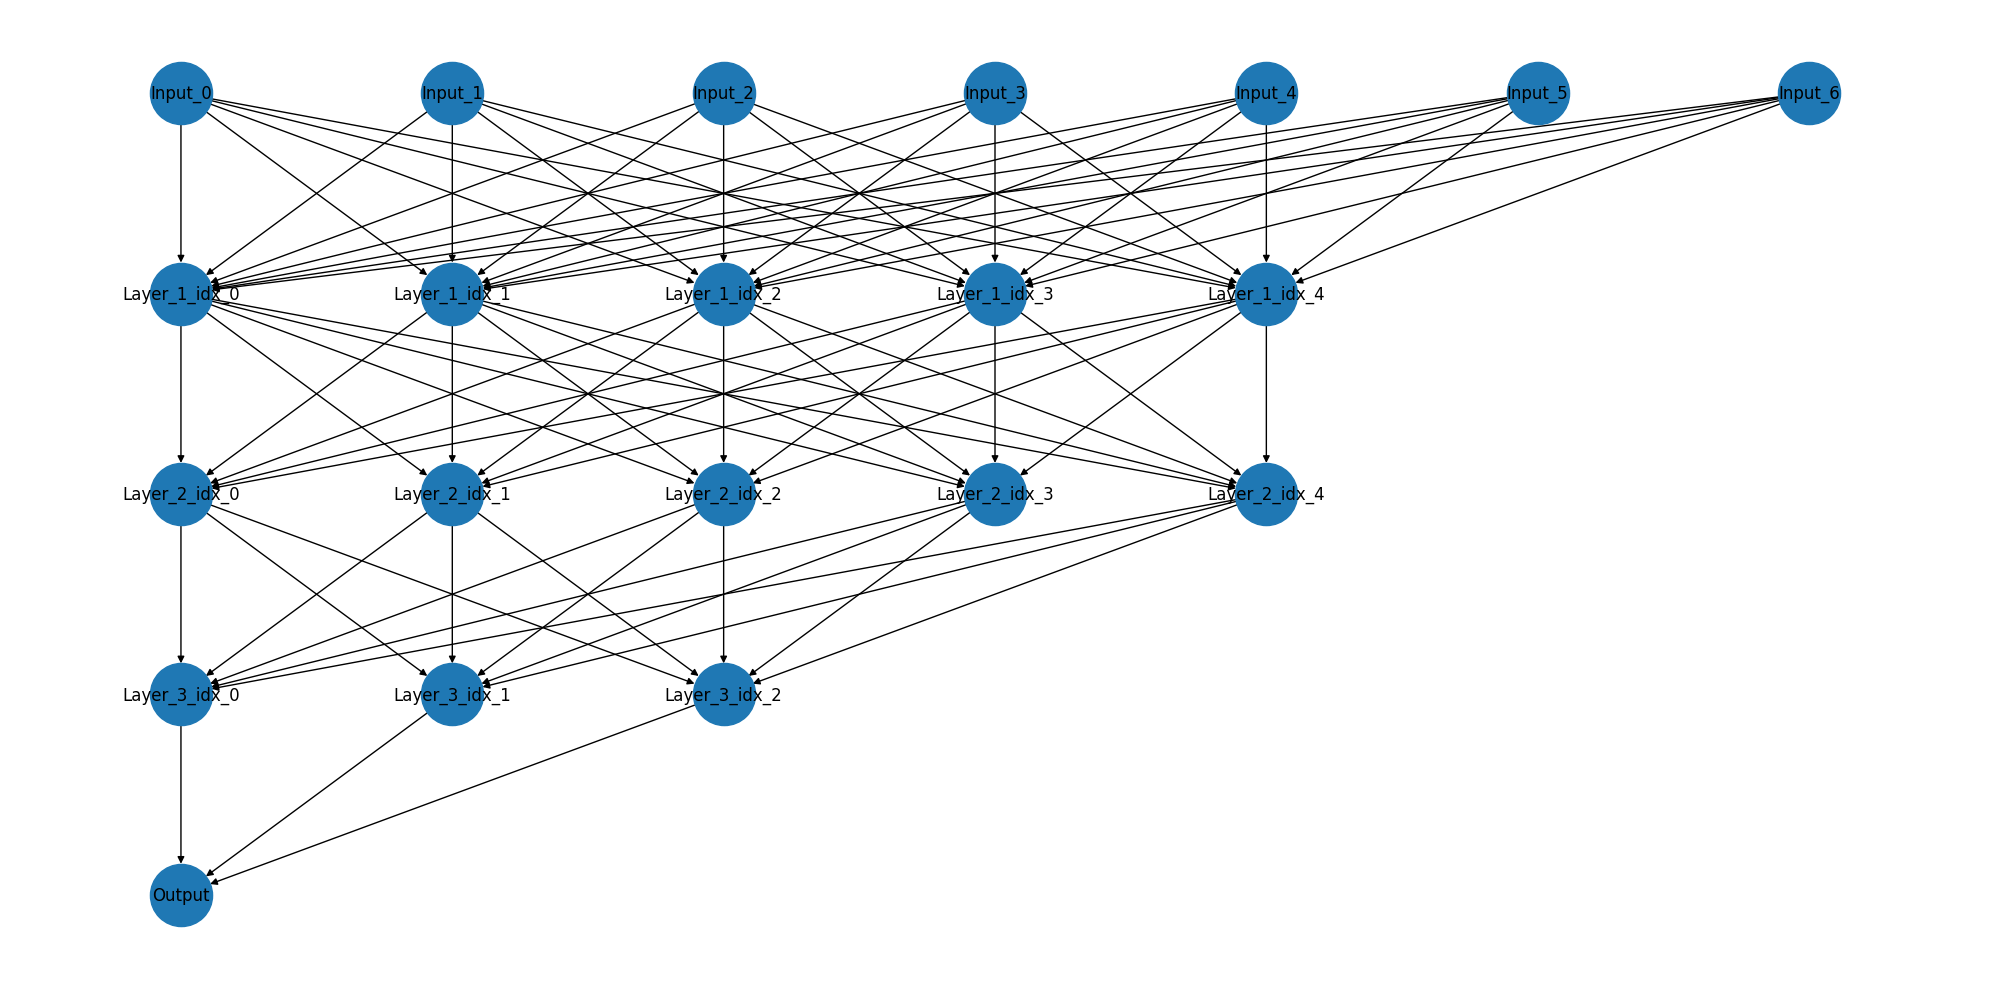

In [235]:
circuit.visualize(figsize=(20, 10))

In [244]:
import torch.nn.functional as F
circuit
state_circuit = circuit.acdc(agent.model, 0.1, F.mse_loss, 10)
circuit.set_sampler(sample_state_probs)
prob_circuit = circuit.acdc(agent.model, 0.05, F.mse_loss, 10)
circuit.set_sampler(sample_state_flips)
flip_circuit = circuit.acdc(agent.model, 0.05, F.mse_loss, 10)
circuit.set_sampler(sample_state_num_flips)
num_flip_circuit = circuit.acdc(agent.model, 0.15, F.mse_loss, 10)

Layer 0


100%|██████████| 1/1 [00:00<00:00,  3.50it/s]


Layer 1


100%|██████████| 3/3 [00:01<00:00,  1.94it/s]


Layer 2


100%|██████████| 3/3 [00:01<00:00,  2.08it/s]


Layer 3


100%|██████████| 6/6 [00:05<00:00,  1.07it/s]


Layer 4


100%|██████████| 18/18 [00:00<?, ?it/s]


Layer 0


100%|██████████| 1/1 [00:00<00:00,  2.77it/s]


Layer 0


100%|██████████| 1/1 [00:00<00:00,  2.04it/s]


Layer 0


100%|██████████| 1/1 [00:00<00:00,  2.89it/s]


Layer 1


100%|██████████| 3/3 [00:01<00:00,  2.17it/s]


Layer 2


100%|██████████| 6/6 [00:03<00:00,  1.69it/s]


Layer 3


100%|██████████| 8/8 [00:06<00:00,  1.32it/s]


Layer 4


100%|██████████| 27/27 [00:00<?, ?it/s]


Layer 0


100%|██████████| 1/1 [00:03<00:00,  3.32s/it]


Layer 1


100%|██████████| 3/3 [00:32<00:00, 10.79s/it]


Layer 2


100%|██████████| 3/3 [00:36<00:00, 12.04s/it]


Layer 3


100%|██████████| 4/4 [01:06<00:00, 16.53s/it]


Layer 4


100%|██████████| 5/5 [00:00<?, ?it/s]


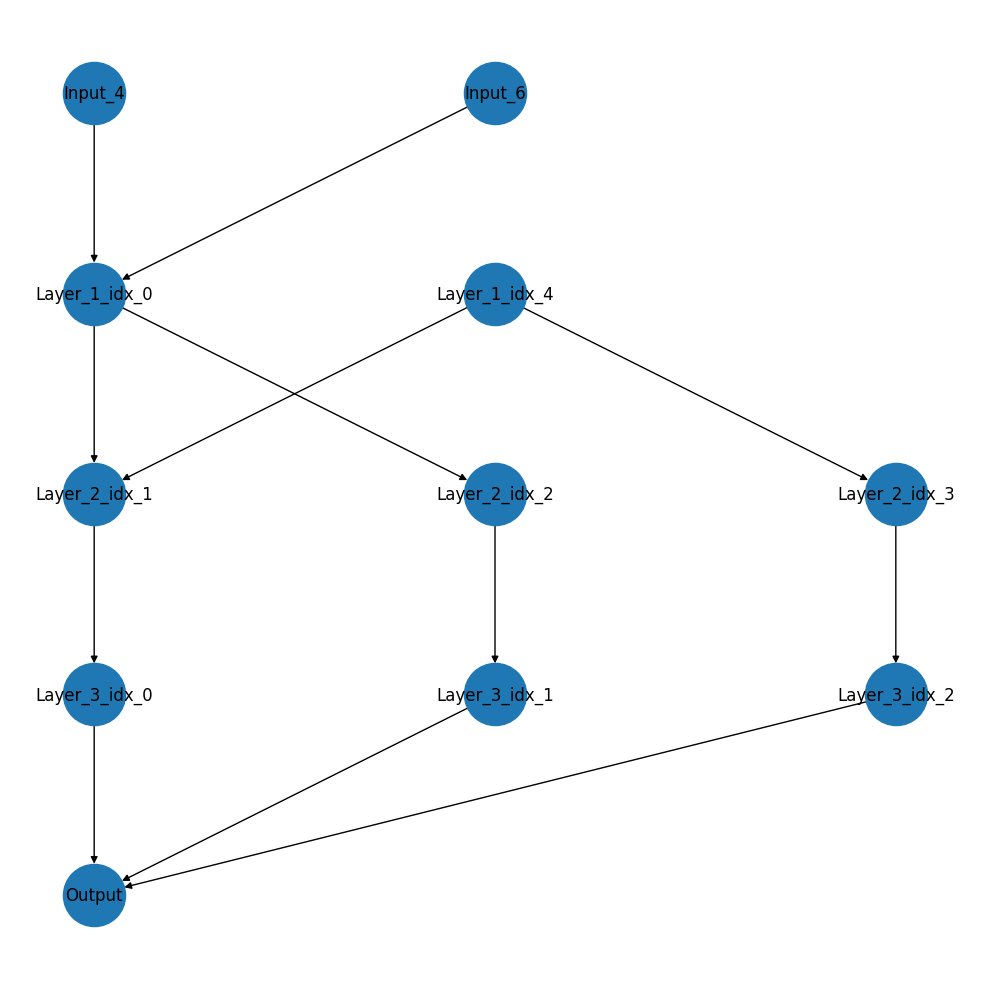

In [253]:
circuit.set_sampler(sample_state_num_flips)
num_flip_circuit = circuit.acdc(agent.model, 0.05, F.mse_loss, 100)
num_flip_circuit.visualize()

In [239]:
from src.agent import CircuitAgent

circ_agent = CircuitAgent(acdc_circuit)
ui.score(circ_agent,100)
ui.score(agent,100)

Average of 2.35 heads across 100 games
Average of 3.16 heads across 100 games


In [162]:
circuit.ha

Output
    Layer_3_idx_0
        Layer_2_idx_0
            Layer_1_idx_0
                Input_0
                Input_1
                Input_2
                Input_3
                Input_4
                Input_5
                Input_6
            Layer_1_idx_1
                Input_0
                Input_1
                Input_2
                Input_3
                Input_4
                Input_5
                Input_6
            Layer_1_idx_2
                Input_0
                Input_1
                Input_2
                Input_3
                Input_4
                Input_5
                Input_6
            Layer_1_idx_3
                Input_0
                Input_1
                Input_2
                Input_3
                Input_4
                Input_5
                Input_6
            Layer_1_idx_4
                Input_0
                Input_1
                Input_2
                Input_3
                Input_4
                Input_5
       

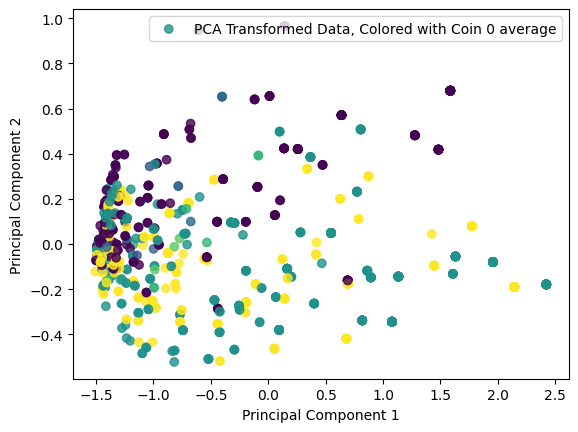

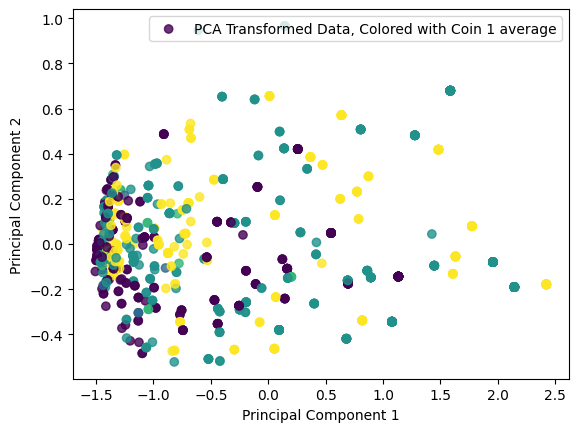

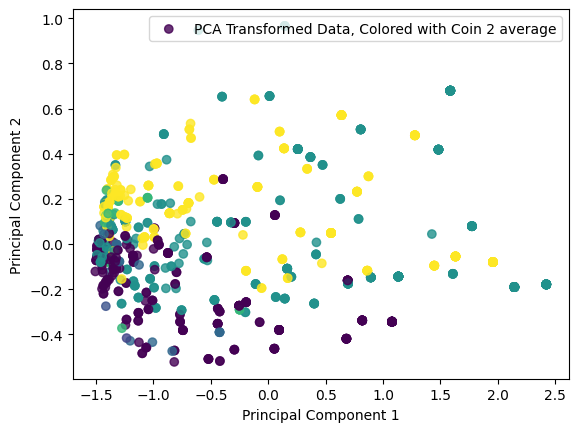

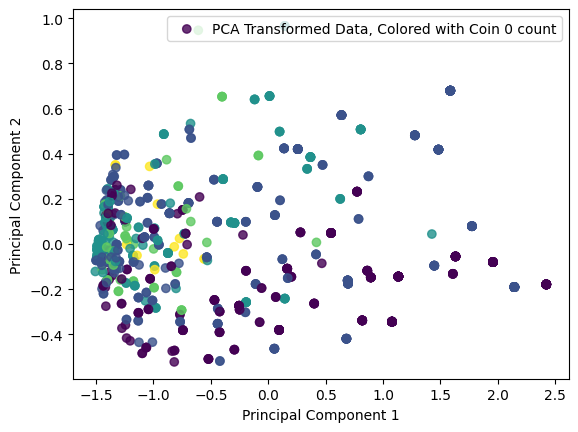

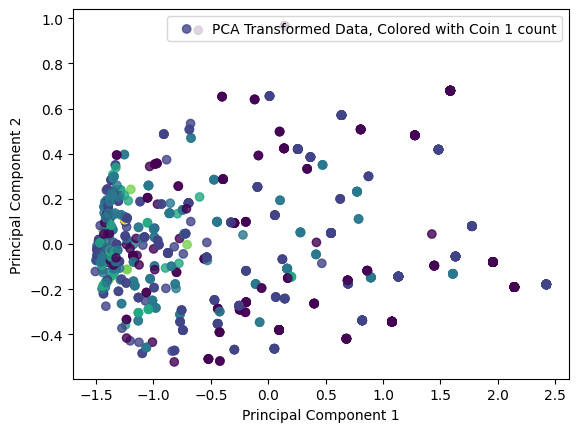

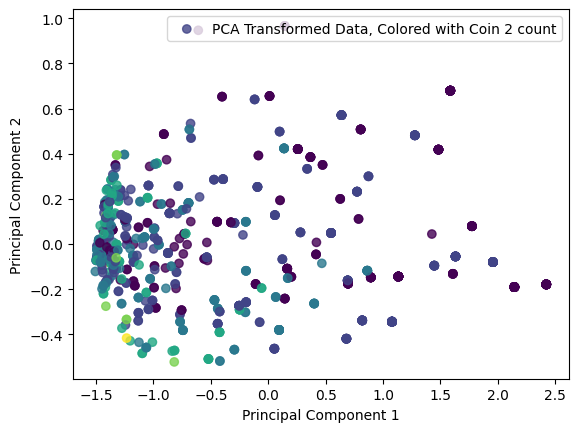

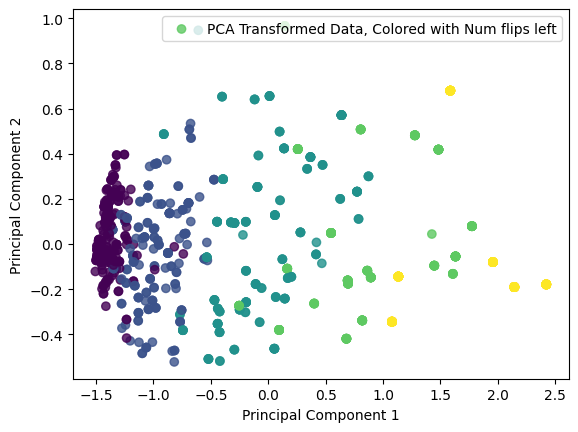

In [32]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
states = [sample_state() for _ in range(1000)]
states_np = np.array([agent.model[:-1](state).detach().numpy() for state in states])
pca = PCA(n_components=2)
data_pca = pca.fit_transform(states_np)
# plt.scatter(states_np[:, 0], states_np[:, 1], alpha=0.8, label='Original Data')
def plot_pca(names, colors):
    for name, color in zip(names, colors):
        plt.scatter(data_pca[:, 0], data_pca[:, 1], alpha=0.8, label=f'PCA Transformed Data, Colored with {name}', c = color)
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.legend()
        plt.show()

names = [f"Coin {i} average" for i in range(num_coin)] + [f"Coin {i} count" for i in range(num_coin)] + ["Num flips left"]
colors = [[state[i] for state in states] for i in range(2*num_coin+1)]
plot_pca(names, colors)


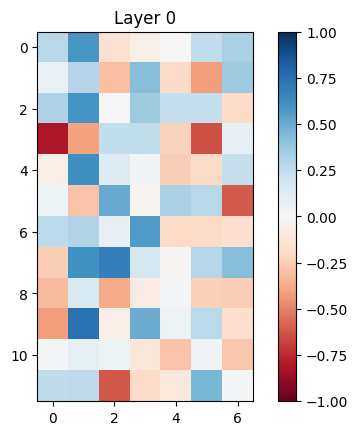

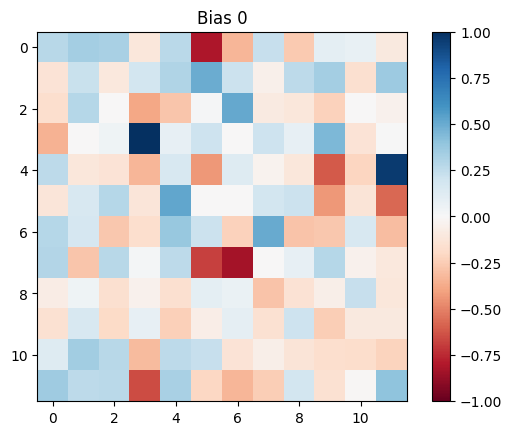

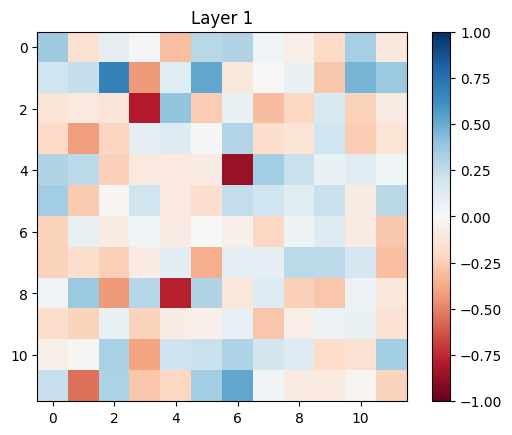

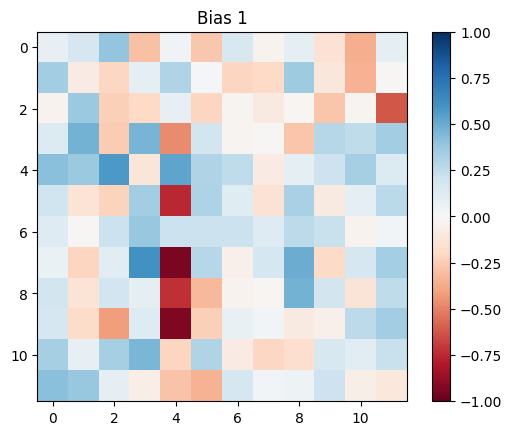

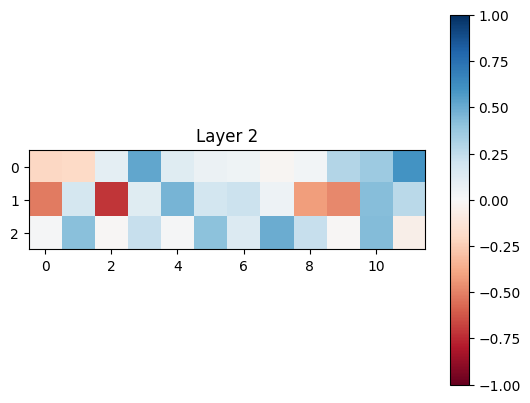

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.parameter

def plot_layer(param:torch.nn.parameter.Parameter, name:str):
    if len(param.shape) == 1:
        param = param.unsqueeze(0)
    param_np = param.detach().numpy()
    plt.imshow(param_np, cmap='RdBu', interpolation='nearest', vmin=-1, vmax=1)
    plt.colorbar()
    plt.title(name)
    plt.show()
    
params = agent.model.parameters()
layer_names = []
for i in range(3):
    layer_names.extend((f"Layer {i}", f"Bias {i}"))
for param, name in zip(params, layer_names):
    plot_layer(param, name)


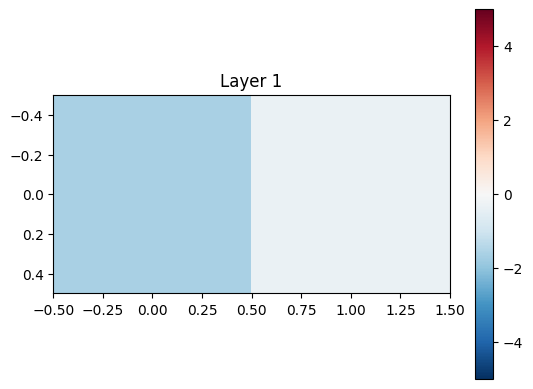

In [34]:
state = torch.tensor([0.0, 0.0, 0.0, 0, 0, 0, 0.0])
activation_lens(agent.model, state, figsize=(10, 2), index = 1, transform = pca.transform)

In [43]:
from src.interp.circuit import acdc
import torch.nn.functional as F

acdc(
    circuit = circuit,
    model = agent.model,
    threshold=0,
    loss_fn = lambda x, y : F.cross_entropy(x, F.softmax(y,dim = -1))
)

[autoreload of src.interp.circuit failed: Traceback (most recent call last):
  File "C:\Users\olive\AppData\Roaming\Python\Python310\site-packages\IPython\extensions\autoreload.py", line 273, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\olive\AppData\Roaming\Python\Python310\site-packages\IPython\extensions\autoreload.py", line 496, in superreload
    update_generic(old_obj, new_obj)
  File "C:\Users\olive\AppData\Roaming\Python\Python310\site-packages\IPython\extensions\autoreload.py", line 393, in update_generic
    update(a, b)
  File "C:\Users\olive\AppData\Roaming\Python\Python310\site-packages\IPython\extensions\autoreload.py", line 361, in update_class
    update_instances(old, new)
  File "C:\Users\olive\AppData\Roaming\Python\Python310\site-packages\IPython\extensions\autoreload.py", line 318, in update_instances
    if type(ref) is old:
KeyboardInterrupt
]


KeyboardInterrupt: 

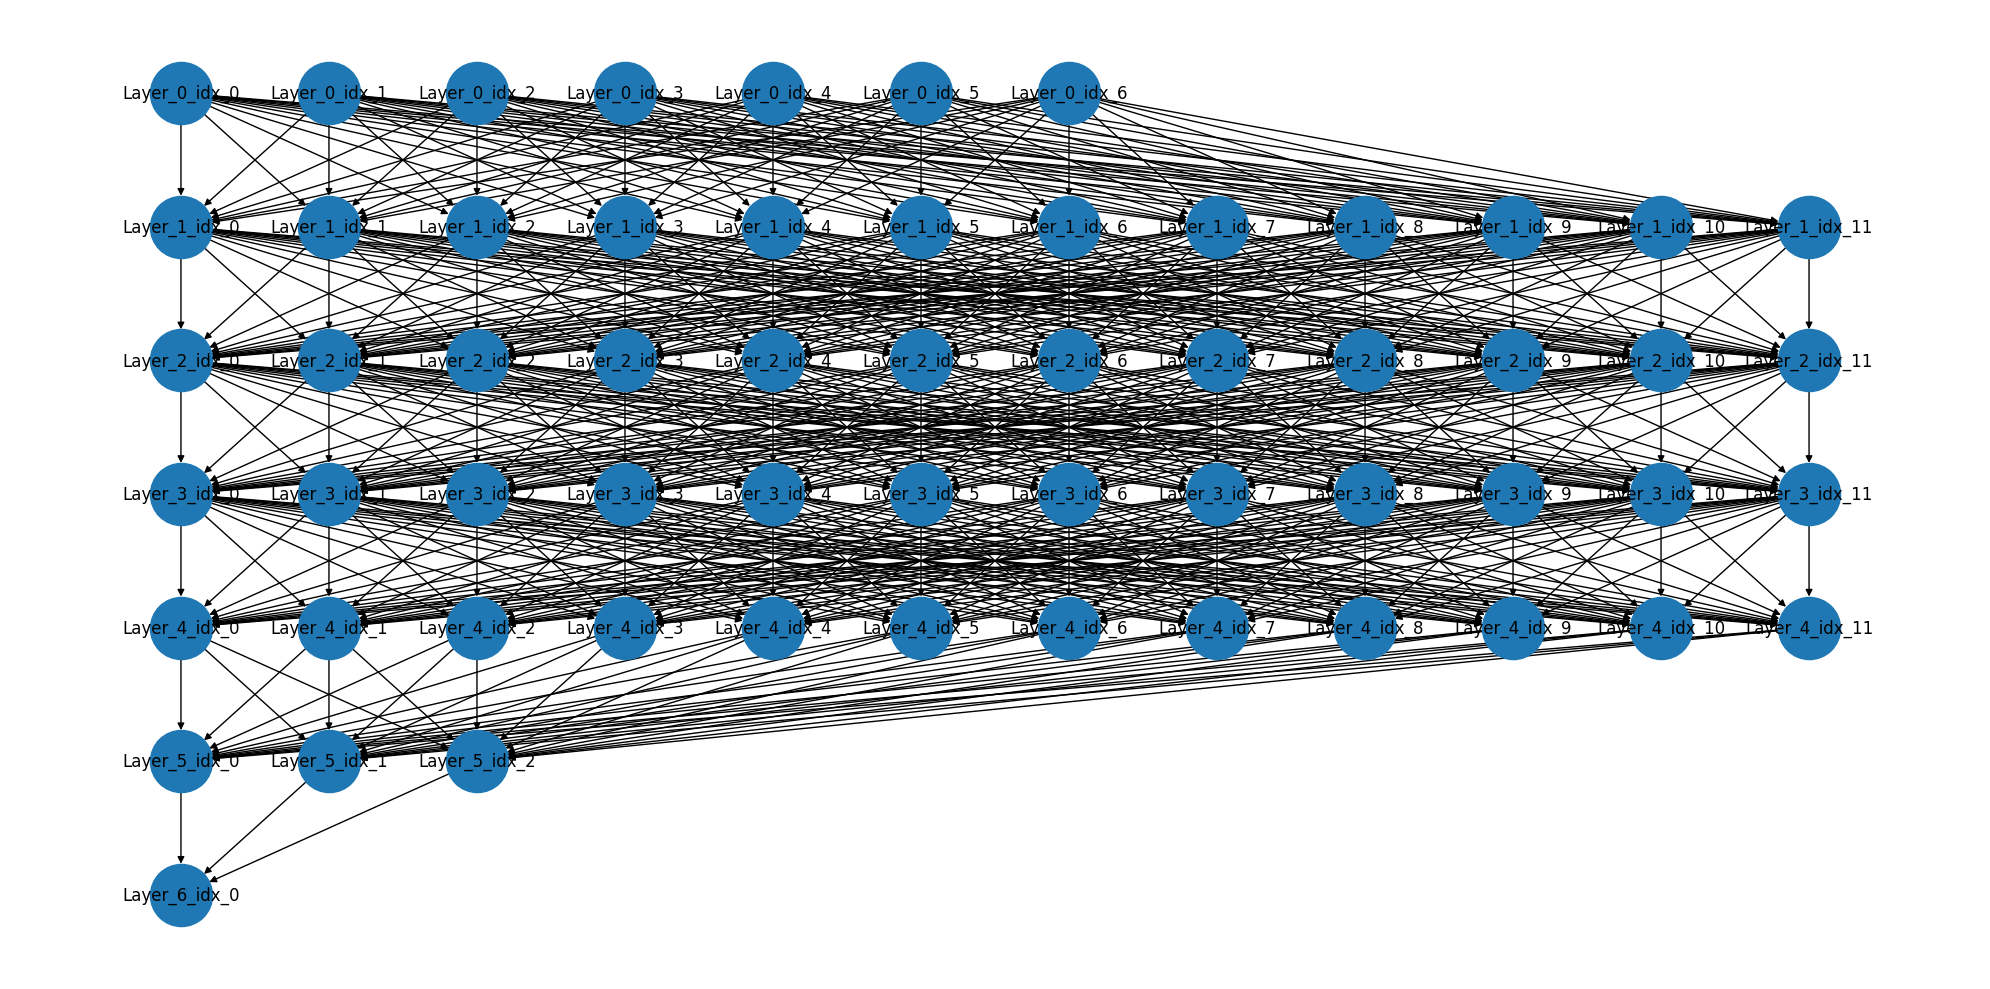

In [47]:
circuit.visualize(figsize=(20, 10))

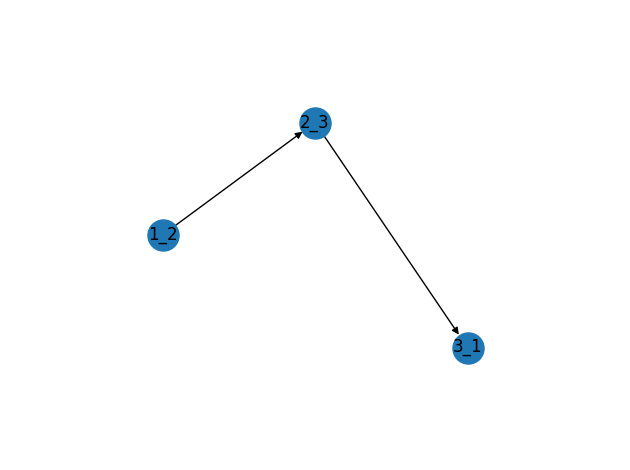

In [24]:
import re
import matplotlib.pyplot as plt 
import networkx as networkx

def plot_directed_graph(vertices, edges):

    G = networkx.DiGraph()
    G.add_nodes_from(vertices)
    G.add_edges_from(edges)
    
    pos = {}
    rows = set()
    cols = set()
    
    for v in vertices:
        # Get positions
        match = re.match(r"(\d+)_(\d+)", v)
        row, col = match.groups()
        rows.add(int(row))
        cols.add(int(col))
        pos[v] = (int(row), int(col)) 
        
    axs = plt.gca()  
    axs.set_xlim(min(cols)-1, max(cols)+1)
    axs.set_ylim(min(rows)-1, max(rows)+1)

    networkx.draw_networkx(G, pos, node_size=500) 
    
    plt.axis("off")
    plt.tight_layout()
    plt.show()

vertices = {"1_2", "2_3", "3_1"} 
edges = [("1_2", "2_3"), ("2_3", "3_1")]

plot_directed_graph(vertices, edges)